# Model training for NFL play prediction

---
 
In this notebook, we train multiple regression and ANN models to predict the yards gained per football play. As a basis we use the preselected data created by the `preprocessing.py``.

### Inline preprocessing steps:

---

As we use 5-fold cross-validation to protect the model against overfitting, we need a dynamic preprocessing appraoch. Therefore a pipeline provided by the `preprocessing.py`` will be used to process the training data of each fold. Further we use a nested cross validation to ensure the quality of our model using selected hyperparameters.


### Contributors

All contributors are only assigned to their primary task, the teams still interchanged know-how and worked on one anothers approaches.

---

##### Preprocessing Team

- Tim Oliver Krause (1689074)
- Jan Thilo Viktorin (1684159)
- Joël Pflomm (1634591)

##### Model Team

- Franziska Köllschen (1981780)
- Steffen Hüls (1979863)
- Matthias Biermanns (1980701)

## Coding

### Coding Foundations

In [43]:
# basic imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.base import TransformerMixin, BaseEstimator
import preprocessing

# import for data visualization
import matplotlib.pyplot as plt

# imports for regression models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import ParameterGrid

import xgboost as xgb

In [2]:
# static variables
FILE_LIST = [f'./Data/play_by_play_{year}.csv' for year in range(1999, 2001)]
PREPROCESSOR = preprocessing.NFLPreprocessing(FILE_LIST)
TARGET_NAME = 'yards_gained'
RANDOM_STATE = 42
LABEL_PASS = 'Pass'
LABEL_RUN = 'Run'

# global variables
model_counter = 0

2023-12-03 00:34:46.632 | INFO     | preprocessing:__init__:56 - --- Executing Preprocessing Steps ---
2023-12-03 00:34:46.633 | INFO     | preprocessing:make_combined_df:143 - Loading csv files
c:\Users\mbier\VSCodeProjects\NFL_play_prediction\preprocessing.py:148: DtypeWarning: Columns (36,37,179,180,189,190,197,198,203,204,205,206,213,214,218,219,220,222,224,226,248,249,253,254,255,260,262,263,266,267,268,269,283,284) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)
c:\Users\mbier\VSCodeProjects\NFL_play_prediction\preprocessing.py:148: DtypeWarning: Columns (37,45,179,180,182,183,189,190,193,194,197,198,203,204,205,206,218,219,220,248,249,253,254,255,260,262,263,283,284) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)
2023-12-03 00:34:48.389 | INFO     | preprocessing:make_combined_df:153 - Successfully loaded csv files
2023-12-03 00:34:48.419 | INFO     | preprocessing:drop

##### General functions

In [19]:
def get_sample(df, data_fraction):
    # set fraction between 0 and 1 (e.g. 0.05 -> 5% df)
    df_sampled = df.sample(frac=data_fraction, random_state=RANDOM_STATE)

    # Reset the index if needed
    df_sampled = df_sampled.reset_index(drop=True)

    return df_sampled

def split_feature_target(df):
    features = df.drop(TARGET_NAME, axis=1)
    target = df[TARGET_NAME]

    return features, target

def plot_predicts(y_test, predictions, label):
    # Evaluate the models
    pass_mse = mean_squared_error(y_test, predictions)
    pass_rmse = mean_squared_error(y_test, predictions, squared = False)
    pass_msa = mean_absolute_error(y_test, predictions)

    # Visualize predictions for passes
    plt.scatter(y_test, predictions)
    plt.title(label + ' Model: True vs Predicted Yards')
    plt.xlabel('True Yards')
    plt.ylabel('Predicted Yards')
    plt.show()

    print(f"Mean Squared Error: {pass_mse}")
    print(f"Mean Absolute Error: {pass_msa}")
    print(f"Root Mean Squared Error: {pass_rmse}")

def plot_decision_tree(tree, label):
    # Plot the decision tree for runs
    plt.figure(figsize=(15, 10))
    plot_tree(tree, filled=True, feature_names=PREPROCESSOR.get_prepro_feature_names_from_pipeline())
    plt.title('Decision Tree for ' + label + ' Model')
    plt.show()

def plot_train_val_loss(training_losses, validation_losses, label):
    # Plot the training and validation loss
    plt.plot(training_losses, label='Training Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Neural Network Training and Validation Loss - ' + label)
    plt.legend()
    plt.show()

def plot_feature_importances(pipeline, label, show_top_n=10):
    # Get feature importances
    feature_importances = pipeline.named_steps['regressor'].feature_importances_

    # Get the feature names after preprocessing
    columns = PREPROCESSOR.get_prepro_feature_names_from_pipeline()

    # Create a DataFrame to display feature importances
    feature_importance_df = pd.DataFrame({'Feature': columns, 'Importance': feature_importances})

    # Sort the DataFrame by importance in descending order
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Plot the feature importances
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df['Feature'][:show_top_n], feature_importance_df['Importance'][:show_top_n])
    plt.xlabel('Importance')
    plt.title(f'Top {show_top_n} Feature Importances - {label}')
    plt.show()

def plot_coef(pipeline):
    coefs = pipeline.named_steps['regressor'].coef_

    # Get the feature names after preprocessing
    columns = PREPROCESSOR.get_prepro_feature_names_from_pipeline()

    coef = pd.DataFrame(coefs, columns=["Coefficients"], index=columns)
    coef.plot(kind="barh", figsize=(9, 7))
    plt.figure(figsize=(10, 6))
    plt.title("Ridge model")
    plt.axvline(x=0, color=".5")
    plt.subplots_adjust(left=0.3)

##### Functions for cross validation

In [26]:
def test_model(pipeline, df, data_fraction: float = None, label = None):
    data = df.copy()
    if(data_fraction and data_fraction < 1.0):
        data = get_sample(data, data_fraction)
    
    features, target = split_feature_target(data)
    X_train, X_test, y_train, y_test = train_test_split(features, target)

    pipeline.fit(X_train, y_train)

    # Make predictions on the test set
    predictions = pipeline.predict(X_test)

    plot_predicts(y_test, predictions, label if label else '')
    save_model(features, target, predictions, label, title_appendix=f'normal_{data_fraction*100}%_of_data')

    return y_test, predictions

def test_model_k_fold(df, pipeline, label, k_folds: int=3, data_fraction: float = 1.0):
    data = df.copy()
    if(data_fraction and data_fraction < 1.0):
        data = get_sample(df, data_fraction)
    
    features, target = split_feature_target(data)

    cv_predictions = cross_val_predict(pipeline, features, target, cv=k_folds)
    
    plot_predicts(target, cv_predictions, label)
    save_model(features, target, cv_predictions, label, title_appendix=f'{k_folds}_folds_{data_fraction*100}%_of_data')
    return cv_predictions

def estimate_hyperparams(df, pipeline, scoring, k_folds=3, parameters={}, data_fraction: float = 1.0):
    data = df.copy()
    if(data_fraction and data_fraction < 1.0):
        data = get_sample(df, data_fraction)

    features, target = split_feature_target(data)
    
    # create the grid search instance
    grid_search_estimator = GridSearchCV(pipeline, parameters, scoring=scoring, cv=k_folds, return_train_score=False)

    # run the grid search
    grid_search_estimator.fit(features, target)
    
    display(grid_search_estimator.best_params_)
    display(pd.DataFrame(grid_search_estimator.cv_results_))

    return grid_search_estimator

def generate_param_combinations(parameters):
    '''list of list required for cross product of two lists'''
    return list(ParameterGrid(parameters))

def save_model(features, target, predictions, label, title_appendix: str = ''):
    global model_counter

    predictions_df = pd.DataFrame({'predicted yards_gained': predictions})
    save_model = pd.concat([features, target, predictions_df], axis=1)

    if (title_appendix != ''):
        title_appendix = '_'+title_appendix
    save_model.to_excel(f'./results/model_{model_counter}_{label}{title_appendix}.xlsx')

    # increase counter for files
    model_counter = model_counter + 1
    pass

##### MLP Regressor Class - with history

In [21]:
class MLPWithHistory(BaseEstimator, TransformerMixin):
    def __init__(self, mlp_params=None):
        self.mlp_params = mlp_params
        self.training_losses = []
        self.validation_losses = []
        self.mlp_regressor = MLPRegressor(**(self.mlp_params or {}))

    def fit(self, X, y):
        X, X_val, y, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

        for epoch in range(self.mlp_regressor.max_iter):
            self.mlp_regressor.partial_fit(X, y)

            # Calculate training loss
            y_train_pred = self.mlp_regressor.predict(X)
            training_loss = mean_squared_error(y, y_train_pred)
            self.training_losses.append(training_loss)

            # Calculate validation loss
            y_val_pred = self.mlp_regressor.predict(X_val)
            validation_loss = mean_squared_error(y_val, y_val_pred)
            self.validation_losses.append(validation_loss)

        return self

    def transform(self, X):
        return X

    def predict(self, X):
        return self.mlp_regressor.predict(X)

    def get_params(self, deep=True):
        return {"mlp_params": self.mlp_params}

    def set_params(self, **params):
        self.mlp_params = params["mlp_params"]
        self.mlp_regressor.set_params(**self.mlp_params)
        return self
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return -mean_squared_error(y, y_pred)

##### Train and Test Data

In [27]:
run_df = PREPROCESSOR.run_df
pass_df = PREPROCESSOR.pass_df

run_features, run_target = split_feature_target(run_df)
pass_features, pass_target = split_feature_target(pass_df)

run_X_train, run_X_test, run_y_train, run_y_test = train_test_split(run_features, run_target)
pass_X_train, pass_X_test, pass_y_train, pass_y_test = train_test_split(pass_features, pass_target)

print(run_features.shape)
print(pass_features.shape)

(27317, 24)
(32303, 24)


### Linear Regression

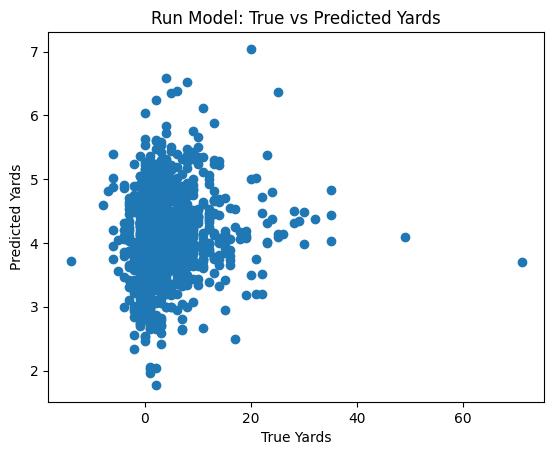

Mean Squared Error: 30.567681914596715
Mean Absolute Error: 3.62508481667754
Root Mean Squared Error: 5.528804745566325


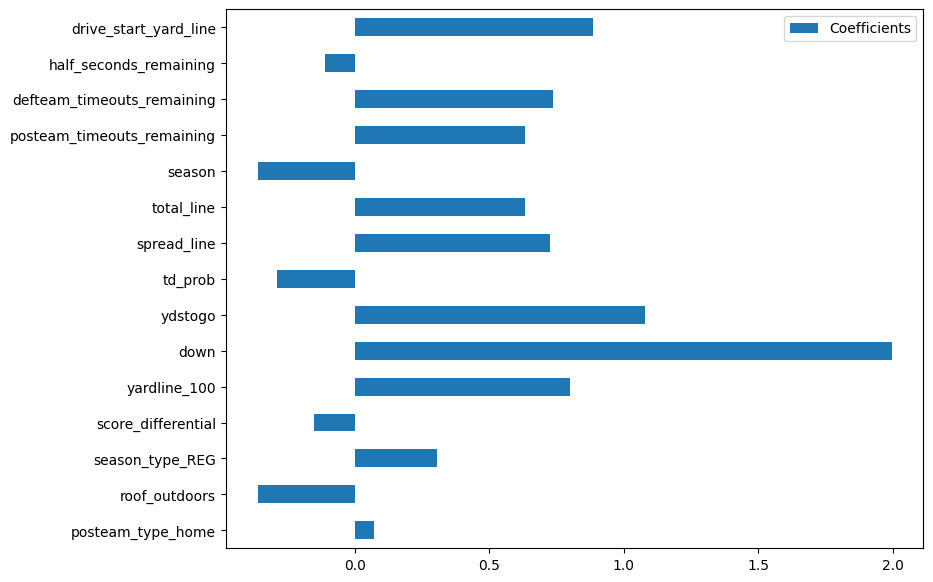

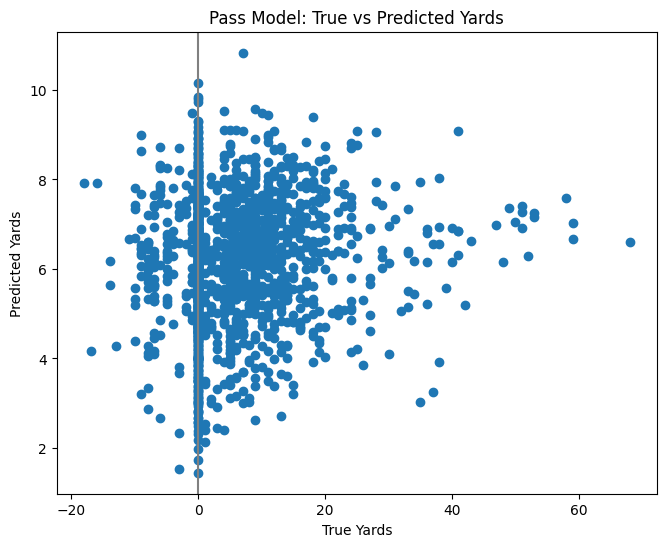

Mean Squared Error: 92.47390271577213
Mean Absolute Error: 7.045776851212969
Root Mean Squared Error: 9.61633520192449


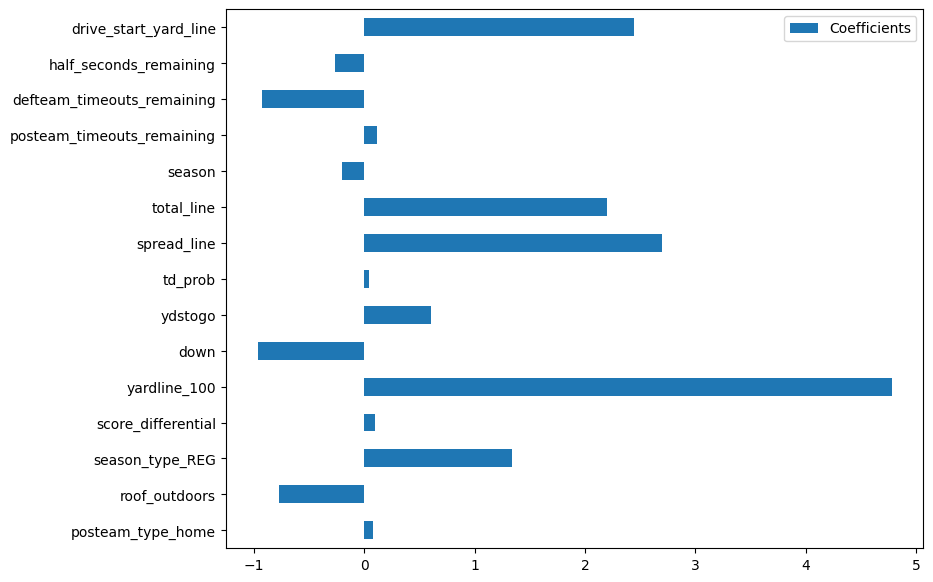

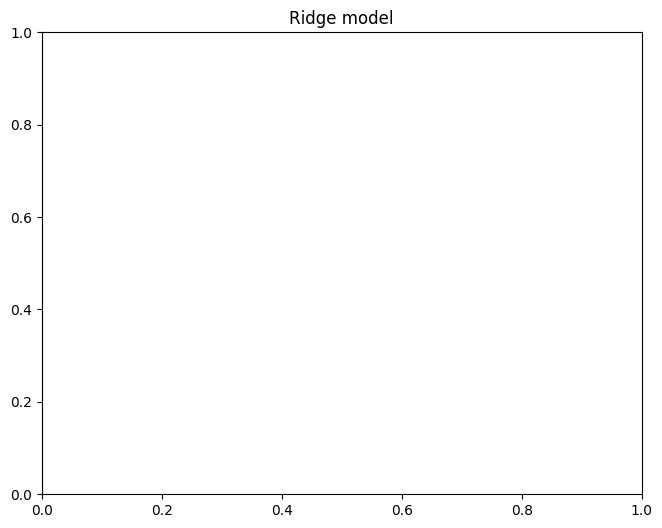

In [28]:
# make pipelines from preprocessing script
pipeline = PREPROCESSOR.make_preprocessing_pipeline(LinearRegression())

run_params = {
    'outlier_remover__kw_args': {
        'strict_factor_iqr': 1.0,
        'loose_factor_iqr': 2.0,
        'strict_columns': ['yardline_100', 'ydstogo'],
        'omit_columns': []
    }
}

pass_params = {
    'outlier_remover__kw_args': {
        'strict_factor_iqr': 1.5,
        'loose_factor_iqr': 3.0,
        'strict_columns': ['ydstogo'],
        'omit_columns': []
    }
}

# set params, test model and save predictions
pipeline = pipeline.set_params(**run_params)
run_y_test, run_predictions = test_model(pipeline, run_df, 0.2, label=LABEL_RUN)
plot_coef(pipeline)

# set params, test model and save predictions
pipeline = pipeline.set_params(**pass_params)
pass_y_test, pass_predictions = test_model(pipeline, pass_df, 0.2, label=LABEL_PASS)
plot_coef(pipeline)

In [8]:
# hyperparameter tuning for linear regression

# could be more over engineered with automatic dict creation if necessary
run_params = {
    'outlier_remover__kw_args': [
        {
            'strict_factor_iqr': 1.0,
            'loose_factor_iqr': 2.0,
            'strict_columns': ['yardline_100', 'ydstogo'],
            'omit_columns': []
        }, {
            'strict_factor_iqr': 1.5,
            'loose_factor_iqr': 3.0,
            'strict_columns': ['yardline_100', 'ydstogo'],
            'omit_columns': []
        },
    ]
}

pass_params = {
    'outlier_remover__kw_args': [{
        'strict_factor_iqr': 1.5,
        'loose_factor_iqr': 3.0,
        'strict_columns': ['ydstogo'],
        'omit_columns': []
    }]
}

pipeline = PREPROCESSOR.make_preprocessing_pipeline(LinearRegression())

run_grid_search = estimate_hyperparams(run_df, pipeline, 'neg_root_mean_squared_error', parameters=run_params, data_fraction=0.25)
pass_grid_search = estimate_hyperparams(pass_df, pipeline, 'neg_root_mean_squared_error', parameters=pass_params, data_fraction=0.25)

{'outlier_remover__kw_args': {'strict_factor_iqr': 1.5,
  'loose_factor_iqr': 3.0,
  'strict_columns': ['yardline_100', 'ydstogo'],
  'omit_columns': []}}

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_outlier_remover__kw_args,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.014718,0.001129,0.006174,0.001702,"{'strict_factor_iqr': 1.0, 'loose_factor_iqr':...",{'outlier_remover__kw_args': {'strict_factor_i...,-5.990829,-5.743454,-6.084640,-5.939641,0.143915,2
1,0.018996,0.004604,0.004021,0.000689,"{'strict_factor_iqr': 1.5, 'loose_factor_iqr':...",{'outlier_remover__kw_args': {'strict_factor_i...,-5.992607,-5.717483,-6.072598,-5.927563,0.152096,1


{'outlier_remover__kw_args': {'strict_factor_iqr': 1.5,
  'loose_factor_iqr': 3.0,
  'strict_columns': ['ydstogo'],
  'omit_columns': []}}

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_outlier_remover__kw_args,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.016395,0.000899,0.004672,0.001025,"{'strict_factor_iqr': 1.5, 'loose_factor_iqr':...",{'outlier_remover__kw_args': {'strict_factor_i...,-9.698035,-10.490504,-9.564956,-9.917832,0.408569,1


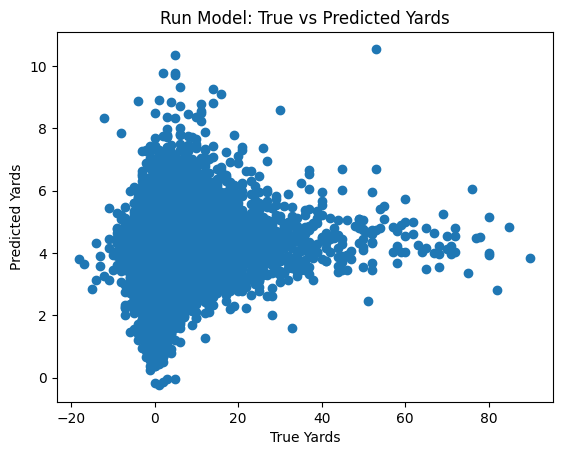

Mean Squared Error: 36.87623361662793
Mean Absolute Error: 3.7608193460564023
Root Mean Squared Error: 6.0725804742817475


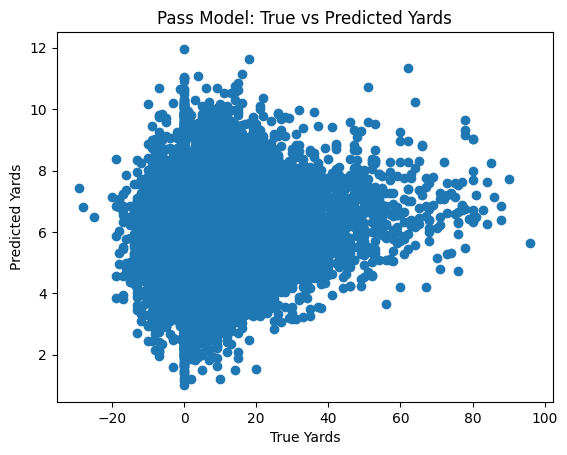

Mean Squared Error: 98.21925366172373
Mean Absolute Error: 7.050303887500172
Root Mean Squared Error: 9.910562731839384


array([6.58738992, 6.29217021, 6.02701876, ..., 3.68337285, 3.36975155,
       3.06119142])

In [29]:
# make pipelines from preprocessing script
pipeline = PREPROCESSOR.make_preprocessing_pipeline(LinearRegression())

run_params = run_grid_search.best_params_
pass_params = pass_grid_search.best_params_

# set params, test model and save predictions
pipeline = pipeline.set_params(**run_params)
run_predictions = test_model_k_fold(run_df, pipeline, LABEL_RUN, data_fraction=1.0)

# set params, test model and save predictions
pipeline = pipeline.set_params(**pass_params)
pass_predictions = test_model_k_fold(pass_df, pipeline, LABEL_PASS, data_fraction=1.0)

### Polynomial Regression

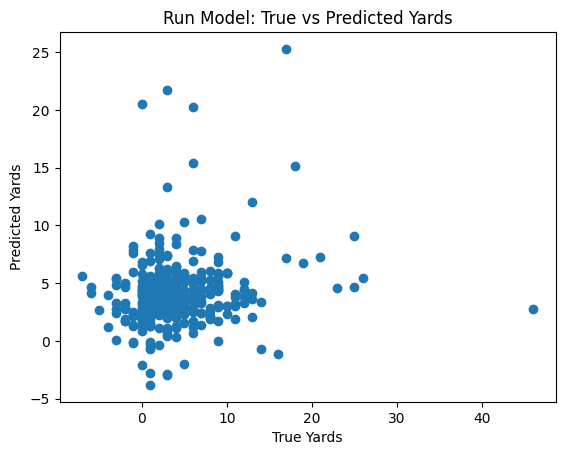

Mean Squared Error: 32.21632773944091
Mean Absolute Error: 3.96467984210678
Root Mean Squared Error: 5.675942894307598


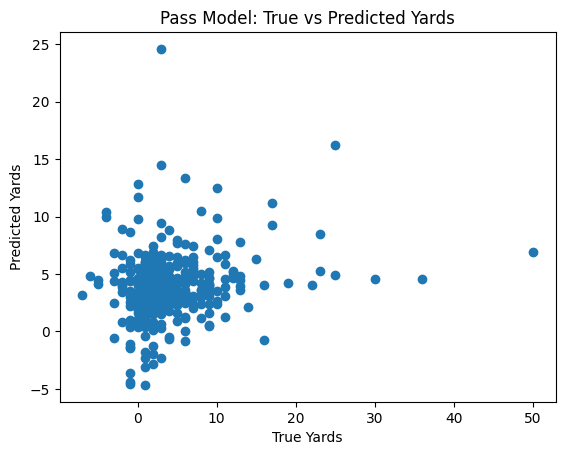

Mean Squared Error: 35.7873700126382
Mean Absolute Error: 3.9940088205693063
Root Mean Squared Error: 5.982254592763351


In [31]:
# basic model

# make pipelines from preprocessing script
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline(make_pipeline(PolynomialFeatures(2), LinearRegression()))
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline(make_pipeline(PolynomialFeatures(2), LinearRegression()))

# test model and save predictions
run_y_test, run_predictions = test_model(run_pipeline, run_df, 0.05, label=LABEL_RUN)
pass_y_test, pass_predictions = test_model(pass_pipeline, run_df, 0.05, label=LABEL_PASS)

In [45]:
# make new pipeliness from preprocessing script
poly_pipeline = Pipeline([('polynomialfeatures', PolynomialFeatures()), ('linear_regression', LinearRegression())])
pipeline = PREPROCESSOR.make_preprocessing_pipeline(poly_pipeline)

parameters = {
    'regressor__polynomialfeatures__degree': [2, 3]
}

run_grid_search = estimate_hyperparams(run_df, pipeline, 'neg_root_mean_squared_error', parameters=parameters, data_fraction=0.2)
pass_grid_search = estimate_hyperparams(pass_df, pipeline, 'neg_root_mean_squared_error', parameters=parameters, data_fraction=0.2)

{'regressor__polynomialfeatures__degree': 2}

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__polynomialfeatures__degree,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.057618,0.001177,0.005037,0.000052,2,{'regressor__polynomialfeatures__degree': 2},-6.089938,-6.037147,-5.708656,-5.945247,0.168677,1
1,0.644899,0.011481,0.010178,0.000477,3,{'regressor__polynomialfeatures__degree': 3},-8.669098,-7.439449,-16.845955,-10.984834,4.174731,2


{'regressor__polynomialfeatures__degree': 2}

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__polynomialfeatures__degree,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.058478,0.000853,0.005509,0.000002,2,{'regressor__polynomialfeatures__degree': 2},-9.714708,-10.514237,-10.233612,-10.154186,0.331203,1
1,0.677501,0.023560,0.011836,0.000458,3,{'regressor__polynomialfeatures__degree': 3},-13.114498,-12.360499,-11.883614,-12.452871,0.506733,2


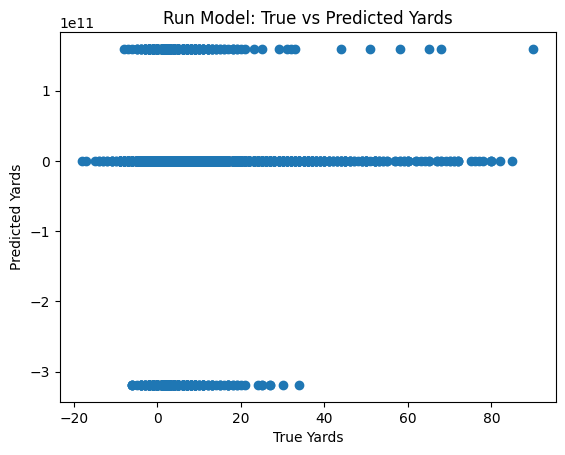

Mean Squared Error: 2.778747370360652e+21
Mean Absolute Error: 10404036171.09199
Root Mean Squared Error: 52713825229.82611


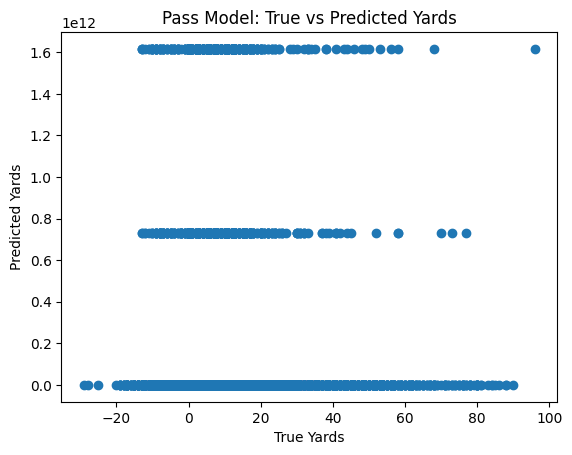

Mean Squared Error: 7.0365908155647436e+22
Mean Absolute Error: 53069024840.40875
Root Mean Squared Error: 265265731212.3966


In [46]:
# cross-validation with best hyperparameters

# make new pipeliness from preprocessing script
poly_pipeline = Pipeline([('polynomialfeatures', PolynomialFeatures()), ('linear_regression', LinearRegression())])
pipeline = PREPROCESSOR.make_preprocessing_pipeline(poly_pipeline)

run_params = run_grid_search.best_params_
pass_params = pass_grid_search.best_params_

# set params, test model and save predictions
pipeline = pipeline.set_params(**run_params)
run_predictions = test_model_k_fold(run_df, pipeline, LABEL_RUN, data_fraction=1.0)

# set params, test model and save predictions
pipeline = pipeline.set_params(**pass_params)
pass_predictions = test_model_k_fold(pass_df, pipeline, LABEL_PASS, data_fraction=1.0)

### KNN

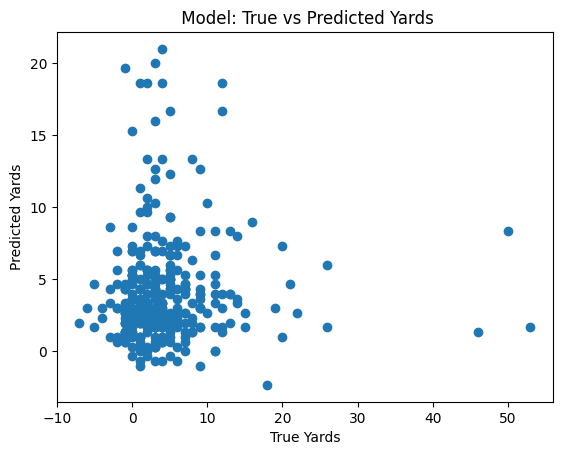

Mean Squared Error: 53.0233918128655
Mean Absolute Error: 4.584795321637427
Root Mean Squared Error: 7.281716268357721


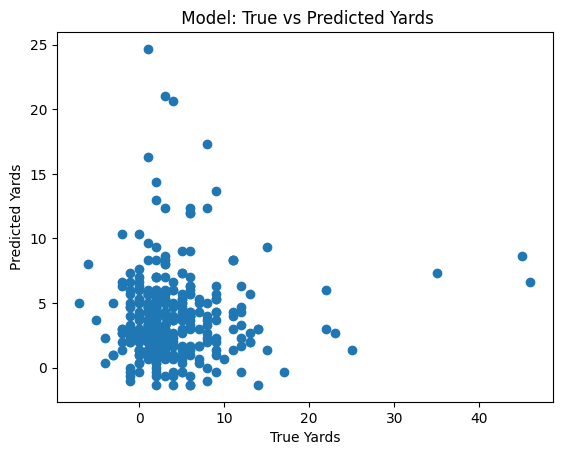

Mean Squared Error: 41.131578947368425
Mean Absolute Error: 4.256335282651072
Root Mean Squared Error: 6.41339059681916


In [47]:
# Basic model

# make pipelines
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline(KNeighborsRegressor(n_neighbors=3))
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline(KNeighborsRegressor(n_neighbors=3))

# test model and save predictions
run_y_test, run_predictions = test_model(run_pipeline, run_df, 0.05)
pass_y_test, pass_predictions = test_model(pass_pipeline, run_df, 0.05)

In [48]:
# estimating hyperparameters

# make new pipeliness from preprocessing script
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline(KNeighborsRegressor())
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline(KNeighborsRegressor())

parameters = {
    'regressor__n_neighbors': range(1, 10)
}

run_grid_search = estimate_hyperparams(run_df, run_pipeline, 'neg_root_mean_squared_error', k_folds=3, parameters=parameters, data_fraction=0.05)
pass_grid_search = estimate_hyperparams(pass_df, pass_pipeline, 'neg_root_mean_squared_error', k_folds=3, parameters=parameters, data_fraction=0.05)

{'regressor__n_neighbors': 9}

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.011170,0.000957,0.004502,4.079560e-04,1,{'regressor__n_neighbors': 1},-8.570400,-7.818125,-7.944588,-8.111038,0.328896,9
1,0.010680,0.001026,0.004834,2.325954e-04,2,{'regressor__n_neighbors': 2},-7.379069,-7.358220,-6.262526,-6.999938,0.521499,8
2,0.011851,0.004047,0.004334,4.703031e-04,3,{'regressor__n_neighbors': 3},-6.906311,-6.874419,-5.798530,-6.526420,0.514860,7
3,0.010494,0.001231,0.005003,8.187754e-04,4,{'regressor__n_neighbors': 4},-6.713861,-6.752075,-5.398120,-6.288019,0.629447,6
4,0.009604,0.000829,0.005003,3.251596e-06,5,{'regressor__n_neighbors': 5},-6.673599,-6.714681,-5.273471,-6.220584,0.669920,5
5,0.010194,0.000487,0.005003,4.495664e-07,6,{'regressor__n_neighbors': 6},-6.595148,-6.675054,-5.123851,-6.131351,0.713157,4
6,0.008820,0.000483,0.005170,2.367529e-04,7,{'regressor__n_neighbors': 7},-6.429866,-6.574533,-5.109968,-6.038123,0.658956,3
7,0.011915,0.001703,0.005207,6.734496e-04,8,{'regressor__n_neighbors': 8},-6.414213,-6.543478,-5.126802,-6.028164,0.639540,2
8,0.010681,0.001036,0.005205,2.153085e-04,9,{'regressor__n_neighbors': 9},-6.378101,-6.523212,-5.086432,-5.995915,0.645824,1


{'regressor__n_neighbors': 9}

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.020678,0.012266,0.006841,0.000622,1,{'regressor__n_neighbors': 1},-13.259435,-13.212799,-13.401368,-13.291201,0.080193,9
1,0.011847,0.000943,0.006008,0.001085,2,{'regressor__n_neighbors': 2},-11.523933,-11.501576,-11.327357,-11.450955,0.087872,8
2,0.013357,0.000637,0.006838,0.000621,3,{'regressor__n_neighbors': 3},-10.811802,-10.847455,-10.524985,-10.728081,0.144346,7
3,0.013391,0.002063,0.008346,0.002265,4,{'regressor__n_neighbors': 4},-10.490205,-10.443449,-10.160240,-10.364632,0.145782,6
4,0.010522,0.001380,0.007565,0.001169,5,{'regressor__n_neighbors': 5},-10.129364,-10.013188,-9.981660,-10.041404,0.063515,5
5,0.011182,0.001327,0.006670,0.000229,6,{'regressor__n_neighbors': 6},-10.049050,-9.814313,-9.871848,-9.911737,0.099896,4
6,0.011339,0.001024,0.006527,0.000818,7,{'regressor__n_neighbors': 7},-9.964537,-9.709663,-9.739494,-9.804565,0.113771,3
7,0.011014,0.001477,0.007802,0.000211,8,{'regressor__n_neighbors': 8},-9.863700,-9.631797,-9.643777,-9.713092,0.106609,2
8,0.017016,0.008261,0.007005,0.001227,9,{'regressor__n_neighbors': 9},-9.843889,-9.641784,-9.643529,-9.709734,0.094865,1


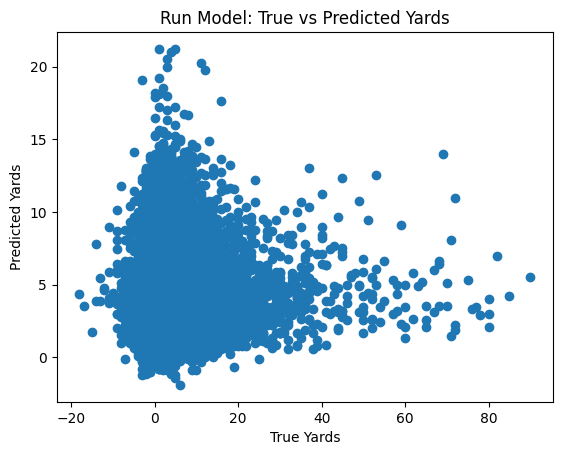

Mean Squared Error: 41.18554493041687
Mean Absolute Error: 4.08289506331019
Root Mean Squared Error: 6.417596507292809


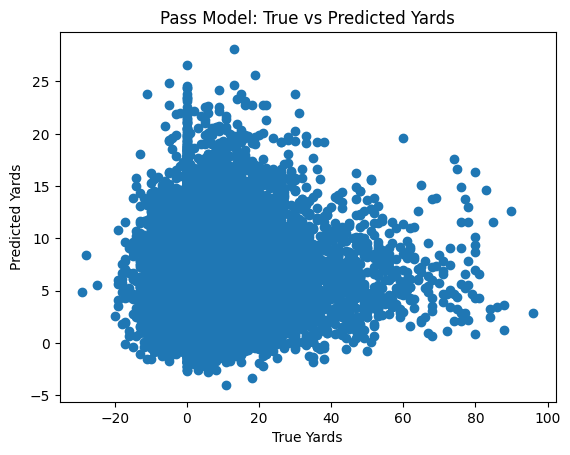

Mean Squared Error: 109.29276759449397
Mean Absolute Error: 7.453521688732041
Root Mean Squared Error: 10.454318131494468


In [49]:
# cross-validation with best hyperparameters

# make new pipeliness from preprocessing script
pipeline = PREPROCESSOR.make_preprocessing_pipeline(KNeighborsRegressor())

run_params = run_grid_search.best_params_
pass_params = pass_grid_search.best_params_

# set params, test model and save predictions
pipeline = pipeline.set_params(**run_params)
run_predictions = test_model_k_fold(run_df, pipeline, LABEL_RUN, data_fraction=1.0)

# set params, test model and save predictions
pipeline = pipeline.set_params(**pass_params)
pass_predictions = test_model_k_fold(pass_df, pipeline, LABEL_PASS, data_fraction=1.0)

### Random Forest

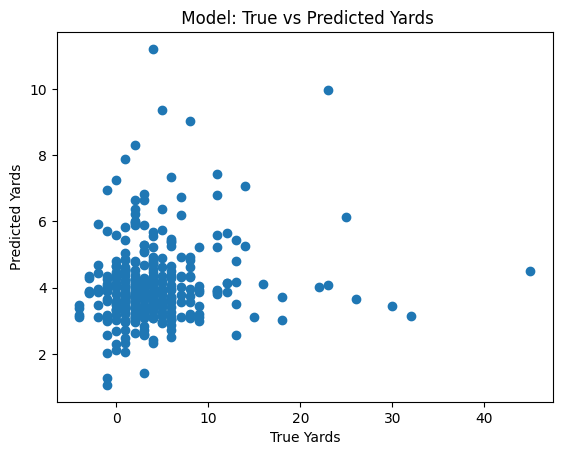

Mean Squared Error: 28.55873827339761
Mean Absolute Error: 3.4536044091990656
Root Mean Squared Error: 5.344037637722774


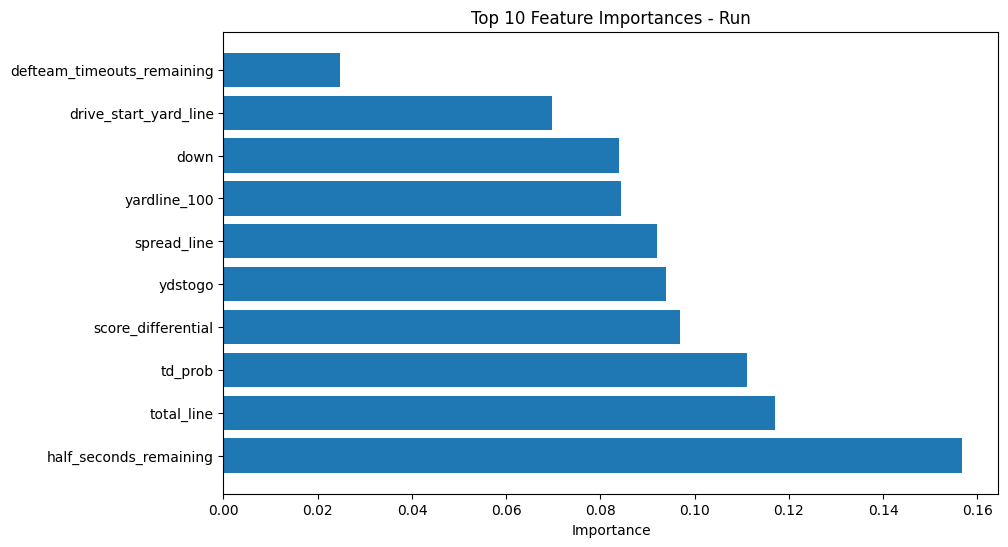

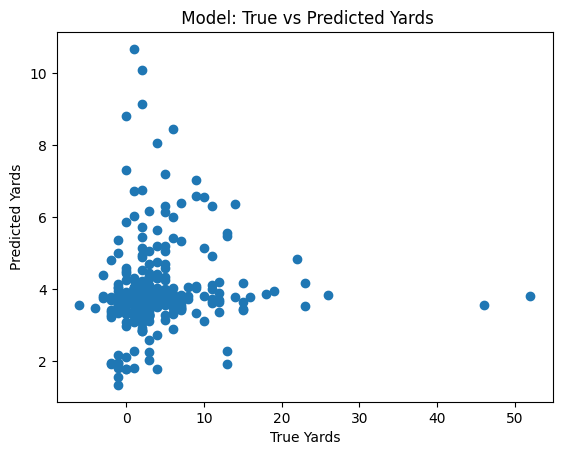

Mean Squared Error: 31.55669975381142
Mean Absolute Error: 3.3974096360545087
Root Mean Squared Error: 5.617535024707137


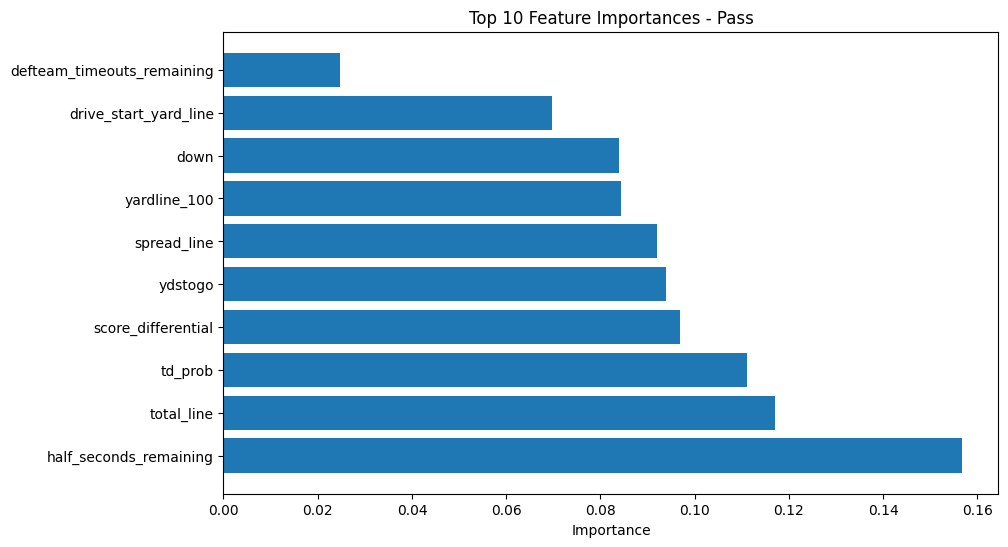

In [50]:
# Basic model

# make pipelines

run_pipeline = PREPROCESSOR.make_preprocessing_pipeline(RandomForestRegressor(n_estimators=100, random_state=42, max_depth=5))
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline(RandomForestRegressor(n_estimators=100, random_state=42, max_depth=5))

# test model and save predictions
run_y_test, run_predictions = test_model(run_pipeline, run_df, 0.05, label=LABEL_RUN)
plot_feature_importances(run_pipeline, LABEL_RUN)

pass_y_test, pass_predictions = test_model(pass_pipeline, run_df, 0.05, label=LABEL_PASS)
plot_feature_importances(run_pipeline, LABEL_PASS)

In [51]:
# estimating hyperparameters

# make new pipeliness from preprocessing script
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline(RandomForestRegressor())
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline(RandomForestRegressor())

parameters = {
    'regressor__max_depth': range(4, 7),
    'regressor__n_estimators': [20, 50, 100]
}

run_grid_search = estimate_hyperparams(run_df, run_pipeline, 'neg_root_mean_squared_error', k_folds=3, parameters=parameters, data_fraction=0.05)
pass_grid_search = estimate_hyperparams(pass_df, pass_pipeline, 'neg_root_mean_squared_error', k_folds=3, parameters=parameters, data_fraction=0.05)

{'regressor__max_depth': 6, 'regressor__n_estimators': 50}

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__max_depth,param_regressor__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.041970,0.001841,0.004842,0.000476,4,20,"{'regressor__max_depth': 4, 'regressor__n_esti...",-6.012013,-6.328590,-4.922119,-5.754241,0.602425,8
1,0.088471,0.002975,0.004748,0.000357,4,50,"{'regressor__max_depth': 4, 'regressor__n_esti...",-5.976446,-6.331971,-4.899677,-5.736031,0.608942,6
2,0.170487,0.004277,0.006051,0.001040,4,100,"{'regressor__max_depth': 4, 'regressor__n_esti...",-5.938884,-6.334836,-4.890240,-5.721320,0.609489,2
3,0.047972,0.001683,0.005673,0.002721,5,20,"{'regressor__max_depth': 5, 'regressor__n_esti...",-5.888507,-6.375815,-4.933163,-5.732495,0.599203,4
4,0.102095,0.000287,0.004840,0.000471,5,50,"{'regressor__max_depth': 5, 'regressor__n_esti...",-5.935158,-6.356790,-4.919660,-5.737203,0.603172,7
5,0.196539,0.005325,0.005951,0.000676,5,100,"{'regressor__max_depth': 5, 'regressor__n_esti...",-5.943122,-6.338711,-4.891711,-5.724515,0.610625,3
6,0.060601,0.011045,0.003670,0.000234,6,20,"{'regressor__max_depth': 6, 'regressor__n_esti...",-6.031748,-6.380451,-4.974170,-5.795456,0.597931,9
7,0.115035,0.001818,0.006328,0.001565,6,50,"{'regressor__max_depth': 6, 'regressor__n_esti...",-5.923760,-6.326445,-4.859829,-5.703345,0.618696,1
8,0.226797,0.006406,0.007517,0.000712,6,100,"{'regressor__max_depth': 6, 'regressor__n_esti...",-5.905015,-6.327783,-4.967665,-5.733487,0.568358,5


{'regressor__max_depth': 4, 'regressor__n_estimators': 100}

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__max_depth,param_regressor__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.043805,0.000618,0.003673,0.000231,4,20,"{'regressor__max_depth': 4, 'regressor__n_esti...",-9.605644,-9.629963,-9.091508,-9.442372,0.248297,3
1,0.102559,0.009534,0.005006,0.000408,4,50,"{'regressor__max_depth': 4, 'regressor__n_esti...",-9.623202,-9.559147,-9.099737,-9.427362,0.233137,2
2,0.191694,0.005694,0.006044,0.000385,4,100,"{'regressor__max_depth': 4, 'regressor__n_esti...",-9.572270,-9.552636,-9.077182,-9.400696,0.228899,1
3,0.053468,0.001281,0.004227,0.000697,5,20,"{'regressor__max_depth': 5, 'regressor__n_esti...",-9.619272,-9.819752,-9.134197,-9.524407,0.287803,9
4,0.109197,0.000711,0.004659,0.000216,5,50,"{'regressor__max_depth': 5, 'regressor__n_esti...",-9.548511,-9.685370,-9.164477,-9.466119,0.220490,5
5,0.219044,0.012529,0.006337,0.000623,5,100,"{'regressor__max_depth': 5, 'regressor__n_esti...",-9.615902,-9.642413,-9.116272,-9.458196,0.242019,4
6,0.059970,0.003848,0.003503,0.000409,6,20,"{'regressor__max_depth': 6, 'regressor__n_esti...",-9.661127,-9.541546,-9.202925,-9.468533,0.194054,6
7,0.123227,0.000590,0.005685,0.000968,6,50,"{'regressor__max_depth': 6, 'regressor__n_esti...",-9.682236,-9.637930,-9.210744,-9.510304,0.212591,8
8,0.253632,0.003362,0.006672,0.000625,6,100,"{'regressor__max_depth': 6, 'regressor__n_esti...",-9.630076,-9.613367,-9.227695,-9.490380,0.185871,7


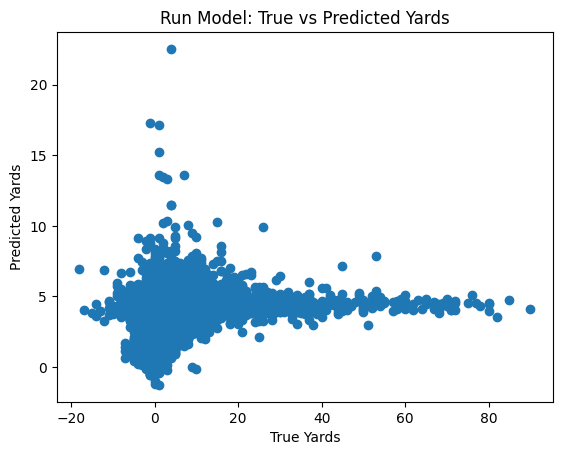

Mean Squared Error: 36.67621300814762
Mean Absolute Error: 3.735826814092667
Root Mean Squared Error: 6.056088920099144


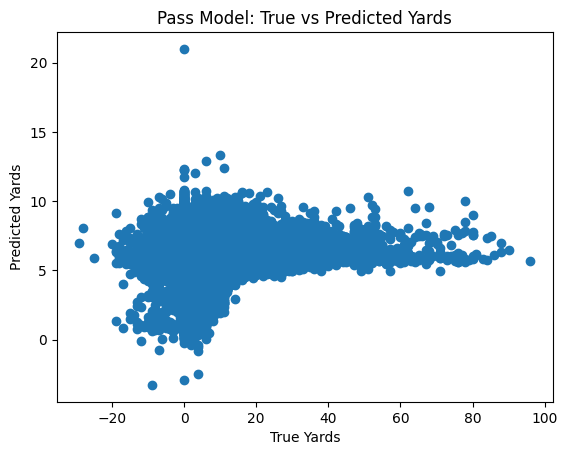

Mean Squared Error: 97.88695626583069
Mean Absolute Error: 7.024405768794419
Root Mean Squared Error: 9.893783718367342


In [52]:
# cross-validation with best hyperparameters

run_features, run_target = split_feature_target(run_df)
pass_features, pass_target = split_feature_target(pass_df)

# make new pipeliness from preprocessing script
pipeline = PREPROCESSOR.make_preprocessing_pipeline(RandomForestRegressor())

run_params = run_grid_search.best_params_
pass_params = pass_grid_search.best_params_

# set params, test model and save predictions
pipeline = pipeline.set_params(**run_params)
run_predictions = test_model_k_fold(run_df, pipeline, LABEL_RUN, data_fraction=1.0)

# set params, test model and save predictions
pipeline = pipeline.set_params(**pass_params)
pass_predictions = test_model_k_fold(pass_df, pipeline, LABEL_PASS, data_fraction=1.0)

Mean Squared Error: 32.506935871156664
Mean Absolute Error: 3.925534407027819
Root Mean Squared Error: 5.701485409185633
Mean Squared Error: 107.4438306930693
Mean Absolute Error: 7.381175742574257
Root Mean Squared Error: 10.365511598231382


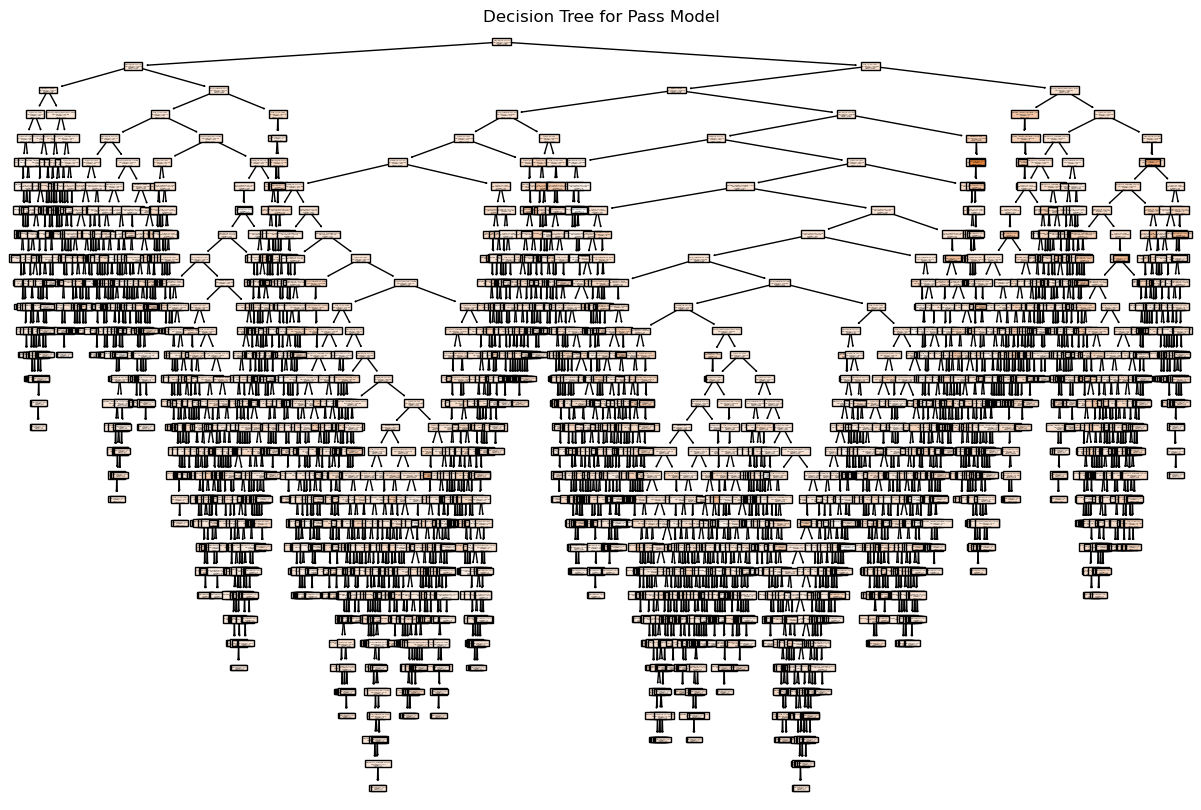

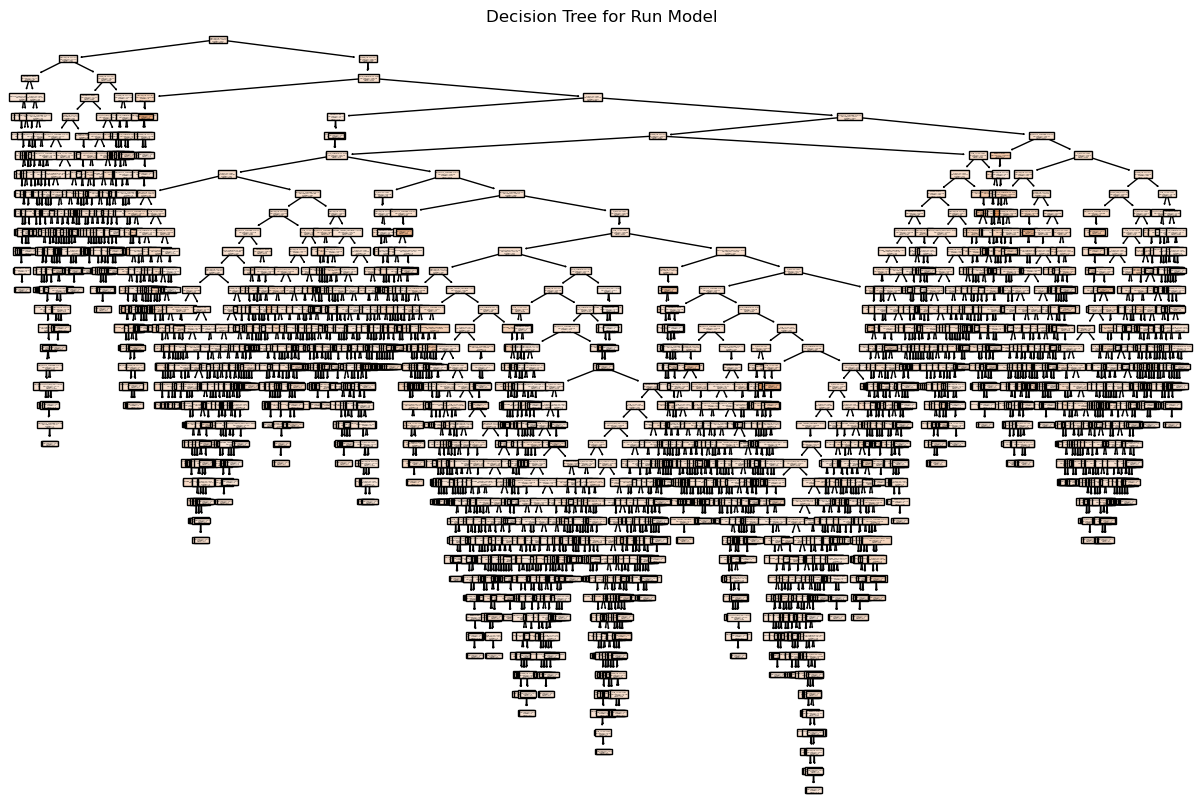

In [57]:
# visualize decision tree
# test model
test_model(run_pipeline, run_X_train, run_y_train, run_X_test, run_y_test)
test_model(pass_pipeline, pass_X_train, pass_y_train, pass_X_test, pass_y_test)

# Access a specific tree from the forest (e.g., the first tree)
tree_to_plot_pass = 0
tree_to_plot_run = 0

pass_rf_regressor = pass_pipeline.named_steps['regressor']
run_rf_regressor = run_pipeline.named_steps['regressor']

# Access the decision tree from the Random Forest
individual_tree_pass = pass_rf_regressor.estimators_[tree_to_plot_pass]
individual_tree_run = run_rf_regressor.estimators_[tree_to_plot_run]

# Plot the decision tree for passes
plot_decision_tree(individual_tree_pass, LABEL_PASS)

# Plot the decision tree for runs
plot_decision_tree(individual_tree_run, LABEL_RUN)

### XGBoost

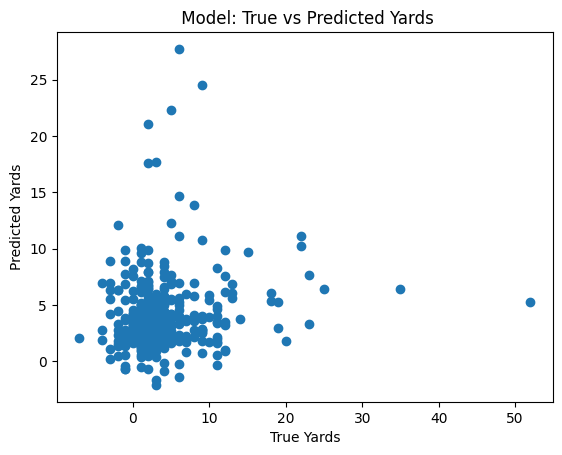

Mean Squared Error: 39.382054618216735
Mean Absolute Error: 4.240750896695413
Root Mean Squared Error: 6.275512299264239


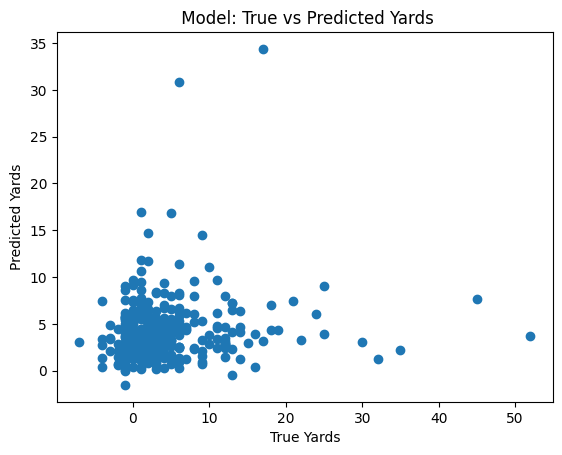

Mean Squared Error: 49.282862708764874
Mean Absolute Error: 4.38991720563792
Root Mean Squared Error: 7.0201754044158236


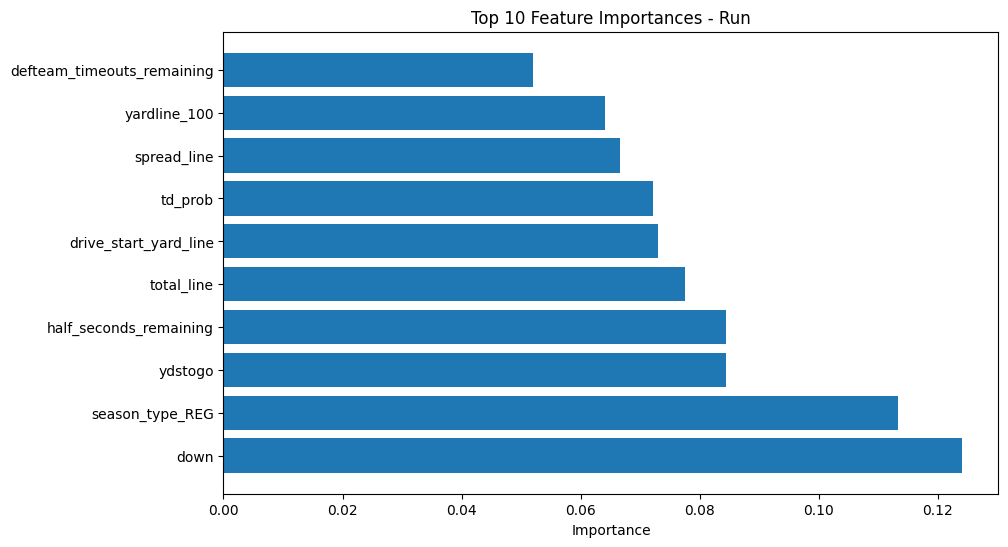

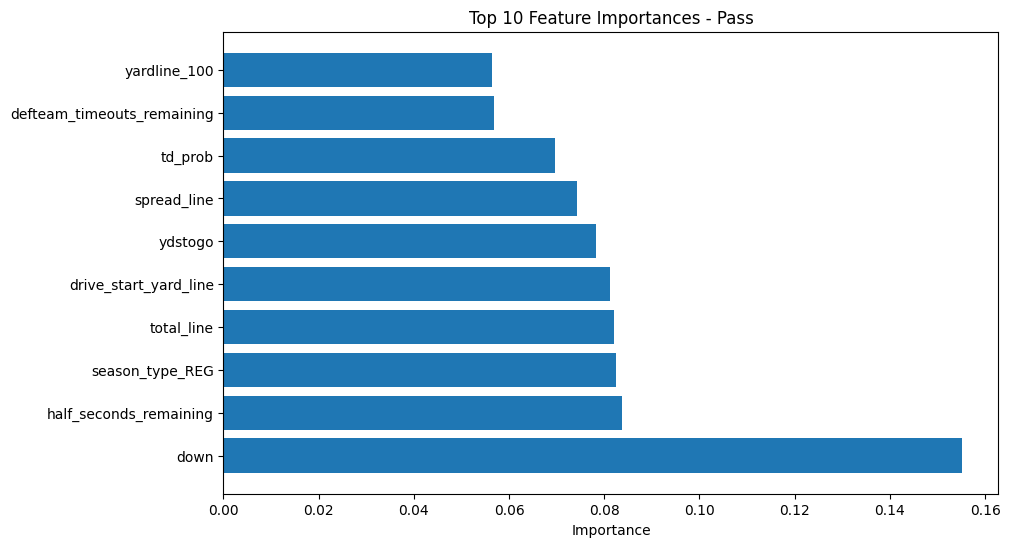

In [53]:
# Basic model

# make pipelines
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline(
    xgb.XGBRegressor(
        learning_rate = 0.022,
        n_estimators  = 1000,
        max_depth     = 8,
        eval_metric='rmsle'
                           )
)
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline(
    xgb.XGBRegressor(
        learning_rate = 0.015,
        n_estimators  = 1000,
        max_depth     = 8,
        eval_metric='rmsle'
        )
)

# test model and save predictions
run_y_test, run_predictions = test_model(run_pipeline, run_df, 0.05)
pass_y_test, pass_predictions = test_model(pass_pipeline, run_df, 0.05)

plot_feature_importances(run_pipeline, LABEL_RUN)
plot_feature_importances(pass_pipeline, LABEL_PASS)

In [54]:
# estimating hyperparameters

# make new pipeliness from preprocessing script
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline(xgb.XGBRegressor())
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline(xgb.XGBRegressor())

parameters = {
    "regressor__max_depth":    [8, 10],
    "regressor__n_estimators": [1000, 1100],
    "regressor__learning_rate": [0.022, 0.015]
}

run_grid_search = estimate_hyperparams(run_df, run_pipeline, 'neg_root_mean_squared_error', k_folds=3, parameters=parameters, data_fraction=0.05)
pass_grid_search = estimate_hyperparams(pass_df, pass_pipeline, 'neg_root_mean_squared_error', k_folds=3, parameters=parameters, data_fraction=0.05)

{'regressor__learning_rate': 0.015,
 'regressor__max_depth': 8,
 'regressor__n_estimators': 1000}

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__learning_rate,param_regressor__max_depth,param_regressor__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.769421,0.016658,0.007173,0.000237,0.022,8,1000,"{'regressor__learning_rate': 0.022, 'regressor...",-6.038412,-6.596418,-5.436941,-6.023924,0.473466,3
1,0.867069,0.028426,0.009175,0.003773,0.022,8,1100,"{'regressor__learning_rate': 0.022, 'regressor...",-6.040150,-6.596529,-5.438799,-6.025159,0.472760,4
2,1.163028,0.005123,0.008192,0.001027,0.022,10,1000,"{'regressor__learning_rate': 0.022, 'regressor...",-6.140195,-6.559546,-5.643702,-6.114481,0.374334,5
3,1.331329,0.027090,0.008509,0.000002,0.022,10,1100,"{'regressor__learning_rate': 0.022, 'regressor...",-6.140275,-6.559711,-5.643943,-6.114643,0.374300,6
4,0.775867,0.038708,0.006177,0.000628,0.015,8,1000,"{'regressor__learning_rate': 0.015, 'regressor...",-6.052271,-6.588630,-5.382792,-6.007898,0.493281,1
5,0.836101,0.037283,0.014187,0.010157,0.015,8,1100,"{'regressor__learning_rate': 0.015, 'regressor...",-6.057868,-6.591479,-5.394387,-6.014578,0.489668,2
6,1.243547,0.014071,0.007845,0.000475,0.015,10,1000,"{'regressor__learning_rate': 0.015, 'regressor...",-6.168822,-6.612668,-5.567605,-6.116365,0.428255,7
7,1.452407,0.051390,0.007841,0.000473,0.015,10,1100,"{'regressor__learning_rate': 0.015, 'regressor...",-6.169465,-6.612866,-5.569636,-6.117323,0.427490,8


{'regressor__learning_rate': 0.015,
 'regressor__max_depth': 8,
 'regressor__n_estimators': 1000}

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__learning_rate,param_regressor__max_depth,param_regressor__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.845145,0.056650,0.007011,0.000814,0.022,8,1000,"{'regressor__learning_rate': 0.022, 'regressor...",-10.630670,-10.672902,-10.223115,-10.508896,0.202812,5
1,0.929637,0.032993,0.013182,0.007734,0.022,8,1100,"{'regressor__learning_rate': 0.022, 'regressor...",-10.636910,-10.676663,-10.228291,-10.513955,0.202646,6
2,1.418143,0.035938,0.009010,0.000706,0.022,10,1000,"{'regressor__learning_rate': 0.022, 'regressor...",-10.650694,-10.564232,-10.280014,-10.498313,0.158345,3
3,1.599312,0.046444,0.008516,0.000416,0.022,10,1100,"{'regressor__learning_rate': 0.022, 'regressor...",-10.651434,-10.564651,-10.280256,-10.498780,0.158529,4
4,0.933033,0.044802,0.007179,0.000941,0.015,8,1000,"{'regressor__learning_rate': 0.015, 'regressor...",-10.589905,-10.604767,-10.135235,-10.443303,0.217921,1
5,0.974461,0.017838,0.013013,0.009194,0.015,8,1100,"{'regressor__learning_rate': 0.015, 'regressor...",-10.607594,-10.610712,-10.147694,-10.455333,0.217537,2
6,1.410762,0.078239,0.007680,0.000240,0.015,10,1000,"{'regressor__learning_rate': 0.015, 'regressor...",-10.639033,-10.771239,-10.335159,-10.581810,0.182569,7
7,1.613158,0.063253,0.008512,0.000003,0.015,10,1100,"{'regressor__learning_rate': 0.015, 'regressor...",-10.643927,-10.775535,-10.337749,-10.585737,0.183401,8


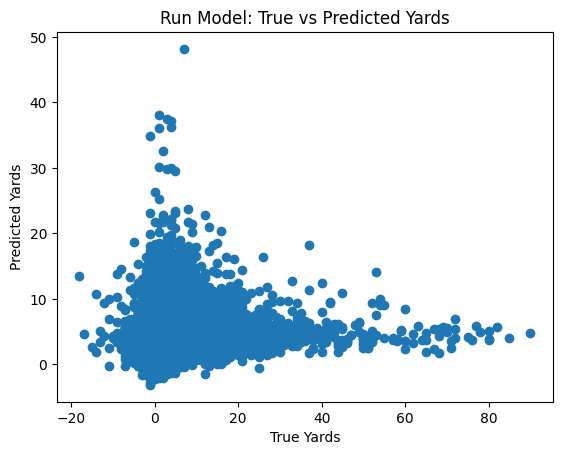

Mean Squared Error: 39.63177139167521
Mean Absolute Error: 3.9349442411383606
Root Mean Squared Error: 6.295376985667754


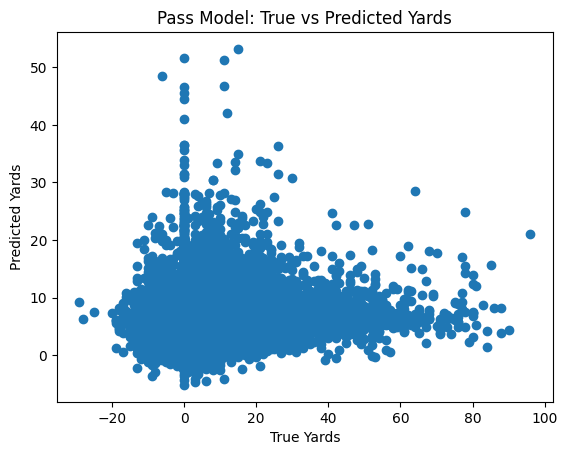

Mean Squared Error: 105.5304984089117
Mean Absolute Error: 7.3542130055041355
Root Mean Squared Error: 10.272803824122784


In [55]:
pipeline = PREPROCESSOR.make_preprocessing_pipeline(xgb.XGBRegressor())

run_params = run_grid_search.best_params_
pass_params = pass_grid_search.best_params_

# set params, test model and save predictions
pipeline = pipeline.set_params(**run_params)
run_predictions = test_model_k_fold(run_df, pipeline, LABEL_RUN, data_fraction=1.0)

# set params, test model and save predictions
pipeline = pipeline.set_params(**pass_params)
pass_predictions = test_model_k_fold(pass_df, pipeline, LABEL_PASS, data_fraction=1.0)

### Artificial Neuronal Network

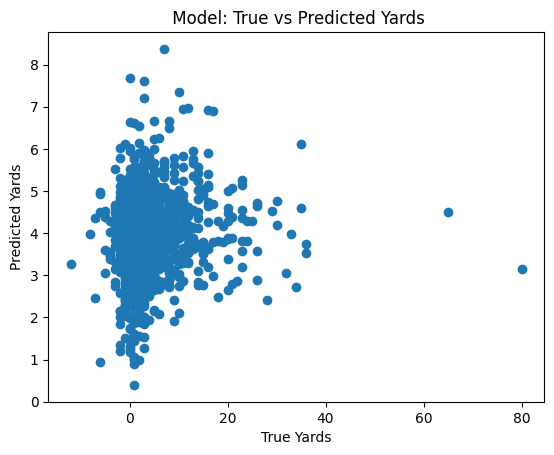

Mean Squared Error: 36.503431651579184
Mean Absolute Error: 3.7516207226511
Root Mean Squared Error: 6.04180698562766


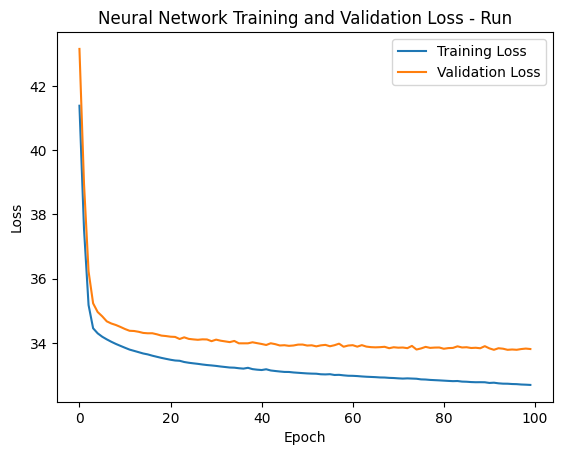

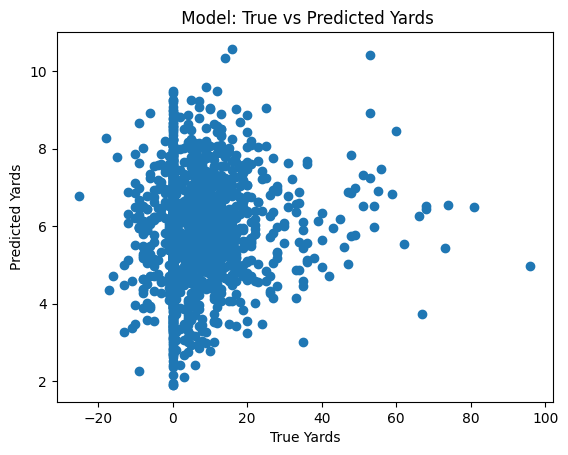

Mean Squared Error: 121.98636967042287
Mean Absolute Error: 7.432264877779512
Root Mean Squared Error: 11.044743983923887


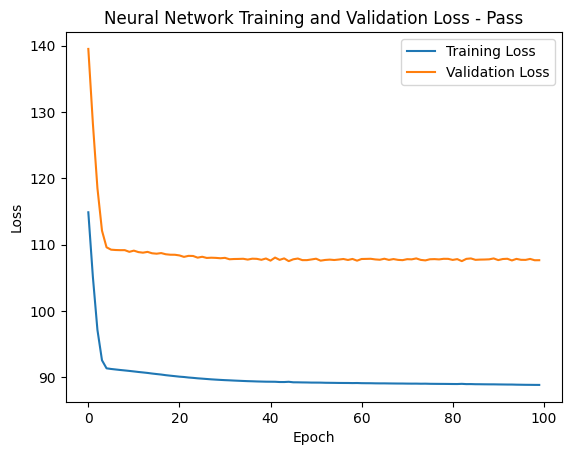

In [56]:
# Basic model

run_pipeline = PREPROCESSOR.make_preprocessing_pipeline(
    MLPWithHistory(
        mlp_params={'hidden_layer_sizes': (50,),
  'activation': 'relu',
  'solver': 'adam',
  'max_iter': 100}
    )
)
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline(
    MLPWithHistory(
        mlp_params={'hidden_layer_sizes': (50,),
  'activation': 'relu',
  'solver': 'adam',
  'max_iter': 100}
    )
)

# estimate run model
run_y_test, run_predictions = test_model(run_pipeline, run_df, 0.2)
run_mlp = run_pipeline.named_steps['regressor']
plot_train_val_loss(run_mlp.training_losses, run_mlp.validation_losses, LABEL_RUN)

# estimate pass model
pass_y_test, pass_predictions = test_model(pass_pipeline, pass_df, 0.2)
pass_mlp = pass_pipeline.named_steps['regressor']
plot_train_val_loss(pass_mlp.training_losses, pass_mlp.validation_losses, LABEL_PASS)

In [63]:
parameters = {
    'regressor__mlp_params': generate_param_combinations({
        'hidden_layer_sizes': [(10,), (50,), (10,5), (20,10)], 
        'activation': ['relu'], 
        'solver': ['adam'], 
        'max_iter': [100] 
    })
}
parameters

{'regressor__mlp_params': [{'activation': 'relu',
   'hidden_layer_sizes': (10,),
   'max_iter': 100,
   'solver': 'adam'},
  {'activation': 'relu',
   'hidden_layer_sizes': (50,),
   'max_iter': 100,
   'solver': 'adam'},
  {'activation': 'relu',
   'hidden_layer_sizes': (10, 5),
   'max_iter': 100,
   'solver': 'adam'},
  {'activation': 'relu',
   'hidden_layer_sizes': (20, 10),
   'max_iter': 100,
   'solver': 'adam'}]}

In [64]:
# estimating hyperparameters

# make new pipeliness from preprocessing script
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline(MLPWithHistory())
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline(MLPWithHistory())

parameters = {
    'regressor__mlp_params': generate_param_combinations({
        'hidden_layer_sizes': [(10,), (50,), (10,5), (20,10)], 
        'activation': ['relu'], 
        'solver': ['adam'], 
        'max_iter': [100] 
    })
    #[
    #    {'hidden_layer_sizes': (10,), 'activation': 'relu', 'solver': 'adam', 'max_iter': 100},
    #    {'hidden_layer_sizes': (50,), 'activation': 'relu', 'solver': 'adam', 'max_iter': 100},
    #    {'hidden_layer_sizes': (10, 5), 'activation': 'relu', 'solver': 'adam', 'max_iter': 100},
    #    {'hidden_layer_sizes': (20, 10), 'activation': 'relu', 'solver': 'adam', 'max_iter': 100},
    #]
}

run_grid_search = estimate_hyperparams(run_df, run_pipeline, 'neg_root_mean_squared_error', k_folds=3, parameters=parameters, data_fraction=0.05)
pass_grid_search = estimate_hyperparams(pass_df, pass_pipeline, 'neg_root_mean_squared_error', k_folds=3, parameters=parameters, data_fraction=0.05)

{'regressor__mlp_params': {'activation': 'relu',
  'hidden_layer_sizes': (20, 10),
  'max_iter': 100,
  'solver': 'adam'}}

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__mlp_params,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.095864,0.004991,0.002336,0.000237,"{'activation': 'relu', 'hidden_layer_sizes': (...",{'regressor__mlp_params': {'activation': 'relu...,-6.186030,-6.356980,-4.843489,-5.795500,0.676781,4
1,0.261658,0.014917,0.004172,0.001035,"{'activation': 'relu', 'hidden_layer_sizes': (...",{'regressor__mlp_params': {'activation': 'relu...,-6.119274,-6.327605,-4.792957,-5.746612,0.679678,2
2,0.118157,0.004875,0.003003,0.000409,"{'activation': 'relu', 'hidden_layer_sizes': (...",{'regressor__mlp_params': {'activation': 'relu...,-6.152627,-6.346971,-4.856351,-5.785317,0.661652,3
3,0.137218,0.000276,0.003334,0.000471,"{'activation': 'relu', 'hidden_layer_sizes': (...",{'regressor__mlp_params': {'activation': 'relu...,-6.094689,-6.335145,-4.802694,-5.744176,0.672927,1


{'regressor__mlp_params': {'activation': 'relu',
  'hidden_layer_sizes': (10, 5),
  'max_iter': 100,
  'solver': 'adam'}}

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__mlp_params,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.119987,0.010275,0.003339,0.000240,"{'activation': 'relu', 'hidden_layer_sizes': (...",{'regressor__mlp_params': {'activation': 'relu...,-9.501400,-9.351952,-9.065858,-9.306403,0.180703,2
1,0.316089,0.009684,0.004005,0.000408,"{'activation': 'relu', 'hidden_layer_sizes': (...",{'regressor__mlp_params': {'activation': 'relu...,-9.495269,-9.354823,-9.088086,-9.312726,0.168876,3
2,0.128600,0.002296,0.003170,0.000238,"{'activation': 'relu', 'hidden_layer_sizes': (...",{'regressor__mlp_params': {'activation': 'relu...,-9.452033,-9.339048,-9.095594,-9.295558,0.148729,1
3,0.150178,0.004179,0.003169,0.000240,"{'activation': 'relu', 'hidden_layer_sizes': (...",{'regressor__mlp_params': {'activation': 'relu...,-9.558877,-9.364352,-9.142279,-9.355169,0.170199,4


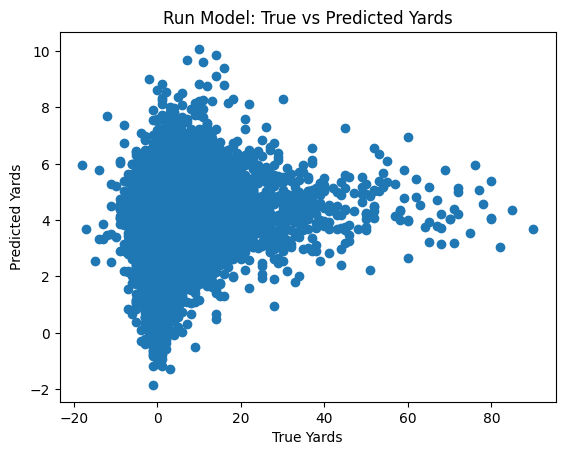

Mean Squared Error: 36.67201637919652
Mean Absolute Error: 3.7204569590244345
Root Mean Squared Error: 6.055742430057319


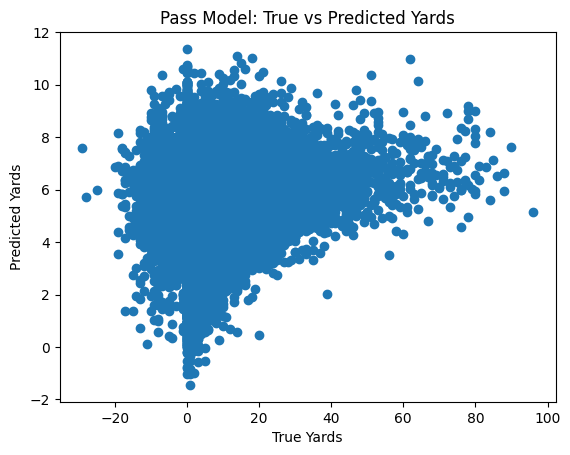

Mean Squared Error: 98.02054510344468
Mean Absolute Error: 7.014323720490793
Root Mean Squared Error: 9.900532566657446


In [65]:
pipeline = PREPROCESSOR.make_preprocessing_pipeline(MLPWithHistory())

run_params = run_grid_search.best_params_
pass_params = pass_grid_search.best_params_

# set params, test model and save predictions
pipeline = pipeline.set_params(**run_params)
run_predictions = test_model_k_fold(run_df, pipeline, LABEL_RUN, data_fraction=1.0)

# set params, test model and save predictions
pipeline = pipeline.set_params(**pass_params)
pass_predictions = test_model_k_fold(pass_df, pipeline, LABEL_PASS, data_fraction=1.0)